# ⚛️ H₂ Ground-State VQE — Noisy Simulation

This notebook studies **VQE under realistic noise** using your production-ready API:

- `run_vqe_optimizer_comparison`
- `run_vqe`

The goal is to understand how noise affects:

- Optimizer stability  
- Convergence  
- The final **noisy density matrix**  
- Basis-state populations  

Noise model (identical for all optimizers):
- **Depolarizing:** 10%  
- **Amplitude damping:** 10%  

These values are intentionally exaggerated to make behavioural differences clear.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from vqe.core import run_vqe_optimizer_comparison, run_vqe
from vqe_qpe_common.plotting import IMG_DIR

# Noise settings
depolarizing_prob = 0.10
amplitude_damping_prob = 0.10

seed = 0

# 🔧 Part 1 — Noisy Optimizer Comparison

We test three optimizers:

- **GradientDescent**
- **Adam**
- **Momentum**

using:

```python
run_vqe_optimizer_comparison(...)
```

This function:
✔ Builds the noisy device  
✔ Runs each optimizer  
✔ Applies both noise channels  
✔ Handles reproducibility + caching  
✔ Saves a convergence plot  
✔ Returns final energies  



⚙️ Running optimizer: GradientDescent
Step 01/75: E = 0.519412 Ha
Step 02/75: E = 0.519386 Ha
Step 03/75: E = 0.519353 Ha
Step 04/75: E = 0.519312 Ha
Step 05/75: E = 0.519260 Ha
Step 06/75: E = 0.519196 Ha
Step 07/75: E = 0.519115 Ha
Step 08/75: E = 0.519013 Ha
Step 09/75: E = 0.518885 Ha
Step 10/75: E = 0.518725 Ha
Step 11/75: E = 0.518523 Ha
Step 12/75: E = 0.518269 Ha
Step 13/75: E = 0.517950 Ha
Step 14/75: E = 0.517550 Ha
Step 15/75: E = 0.517047 Ha
Step 16/75: E = 0.516414 Ha
Step 17/75: E = 0.515621 Ha
Step 18/75: E = 0.514624 Ha
Step 19/75: E = 0.513374 Ha
Step 20/75: E = 0.511806 Ha
Step 21/75: E = 0.509842 Ha
Step 22/75: E = 0.507384 Ha
Step 23/75: E = 0.504313 Ha
Step 24/75: E = 0.500482 Ha
Step 25/75: E = 0.495714 Ha
Step 26/75: E = 0.489795 Ha
Step 27/75: E = 0.482474 Ha
Step 28/75: E = 0.473455 Ha
Step 29/75: E = 0.462403 Ha
Step 30/75: E = 0.448947 Ha
Step 31/75: E = 0.432690 Ha
Step 32/75: E = 0.413234 Ha
Step 33/75: E = 0.390209 Ha
Step 34/75: E = 0.363322 Ha
Step 35/7

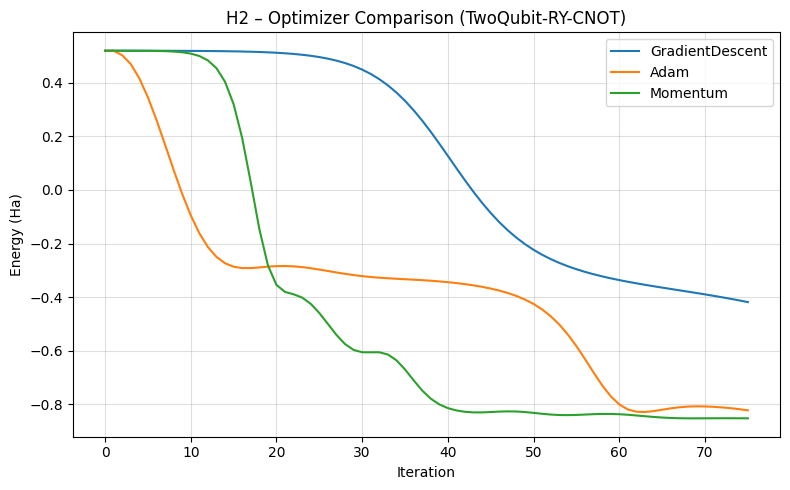

<Figure size 640x480 with 0 Axes>

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/H2_optimizer_comparison_ansTwoQubit-RY-CNOT.png


{'energies': {'GradientDescent': [0.5194119042839198,
   0.5194119042839198,
   0.5193857313069309,
   0.5193529656873027,
   0.5193119110829353,
   0.5192604336873983,
   0.519195849563729,
   0.5191147831334368,
   0.5190129895838481,
   0.5188851318226668,
   0.5187245010741134,
   0.518522666594566,
   0.5182690377524793,
   0.5179503166792021,
   0.5175498161618234,
   0.5170466113589752,
   0.5164144884390119,
   0.5156206464896244,
   0.5146241041009654,
   0.5133737558660422,
   0.51180602390076,
   0.5098420528501999,
   0.5073844125091489,
   0.5043133053389994,
   0.5004823363361495,
   0.49571400571577484,
   0.4897952462825951,
   0.48247356616601467,
   0.47345469375473703,
   0.4624030476188927,
   0.4489468421050028,
   0.4326900865641734,
   0.4132339319958127,
   0.3902094355523851,
   0.36332241209943605,
   0.33240825133720475,
   0.2974903782412943,
   0.2588312270925384,
   0.21696106665767664,
   0.1726703947337465,
   0.12695794520062897,
   0.08093813885648374,

In [2]:
optimizers = ["GradientDescent", "Adam", "Momentum"]

comparison = run_vqe_optimizer_comparison(
    molecule="H2",
    ansatz_name="TwoQubit-RY-CNOT",
    optimizers=optimizers,
    steps=75,
    stepsize=0.1,
    noisy=True,
    depolarizing_prob=depolarizing_prob,
    amplitude_damping_prob=amplitude_damping_prob,
    seed=seed,
    show=True,
    force=False,
)

comparison

# ⭐ Part 2 — Identify the Worst Optimizer

Noise flattens the loss landscape, so optimizers behave differently than in
the noiseless case.  

We define the *worst* optimizer as the one with the **highest final energy**.

In [3]:
worst_optimizer = max(
    comparison["final_energies"],
    key=comparison["final_energies"].get
)

print(f"🏆 Worst optimizer under noise: {worst_optimizer}")

🏆 Worst optimizer under noise: GradientDescent


# 🔍 Part 3 — Full Noisy VQE Using the Worst Optimizer

We now run a complete noisy VQE with:

- Ansatz: **TwoQubit-RY-CNOT**  
- Optimizer: worst performer  
- Depolarizing: 10%  
- Amplitude damping: 10%  

`run_vqe(...)` returns energies, metadata, and the full **noisy density matrix**.

In [4]:
res = run_vqe(
    molecule="H2",
    ansatz_name="TwoQubit-RY-CNOT",
    optimizer_name=worst_optimizer,
    n_steps=75,
    stepsize=0.1,
    noisy=True,
    depolarizing_prob=depolarizing_prob,
    amplitude_damping_prob=amplitude_damping_prob,
    seed=seed,
    plot=False,
    force=False,
)

rho = np.array(res["final_state_real"]) + 1j * np.array(res["final_state_imag"])
diag = np.diag(rho)

diag


📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__TwoQubit-RY-CNOT__GradientDescent__VQE__noisy__s0__10d9e9e51edd.json


array([0.10049489+0.j, 0.00695867+0.j, 0.0277807 +0.j, 0.00192365+0.j,
       0.2207685 +0.j, 0.0152869 +0.j, 0.04218593+0.j, 0.00292112+0.j,
       0.2993641 +0.j, 0.02072917+0.j, 0.09820783+0.j, 0.0068003 +0.j,
       0.12096617+0.j, 0.00837618+0.j, 0.0254721 +0.j, 0.00176379+0.j])

# 🧮 Part 4 — Approximate Ket Representation  

For mixed states, the diagonal entries of ρ correspond to **basis-state
populations**.

We display only those above a small threshold.

In [5]:
threshold = 1e-2
num_wires = int(np.log2(len(diag)))

terms = [
    f"({amp:.4f}|{idx:0{num_wires}b}⟩)"
    for idx, amp in enumerate(diag)
    if abs(amp) > threshold
]

ket_estimate = " + ".join(terms)

print("Approximate noisy state:")
print(f"|ψ⟩ ≈ {ket_estimate}")

Approximate noisy state:
|ψ⟩ ≈ (0.1005+0.0000j|0000⟩) + (0.0278+0.0000j|0010⟩) + (0.2208+0.0000j|0100⟩) + (0.0153+0.0000j|0101⟩) + (0.0422+0.0000j|0110⟩) + (0.2994+0.0000j|1000⟩) + (0.0207+0.0000j|1001⟩) + (0.0982+0.0000j|1010⟩) + (0.1210+0.0000j|1100⟩) + (0.0255+0.0000j|1110⟩)


# 📊 Part 5 — Basis-State Population Plot

The bar plot below visualizes **which computational states survive** after noise.

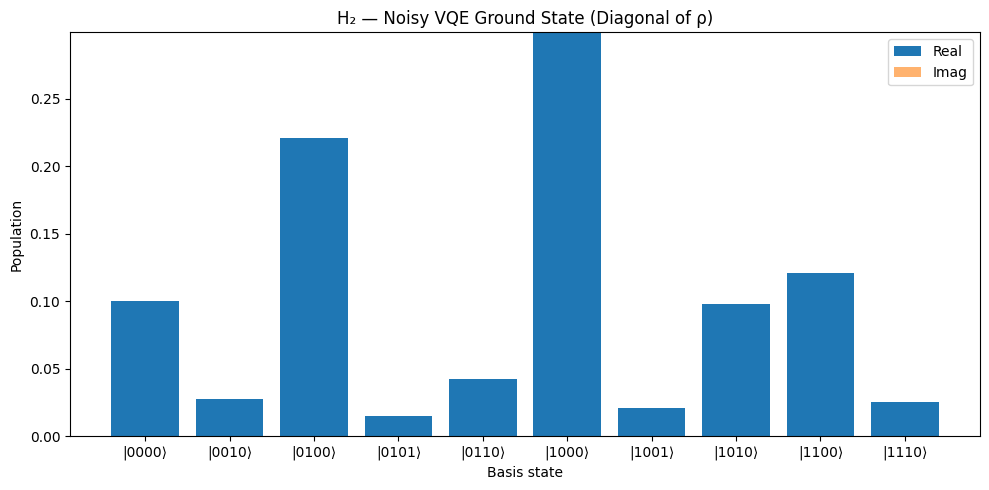

In [6]:
indices = np.where(abs(diag) > threshold)[0]
vals = diag[indices]
labels = [f"|{i:0{num_wires}b}⟩" for i in indices]

plt.figure(figsize=(10, 5))
plt.bar(labels, vals.real, label="Real")
plt.bar(labels, vals.imag, bottom=vals.real, alpha=0.6, label="Imag")

plt.xlabel("Basis state")
plt.ylabel("Population")
plt.title("H₂ — Noisy VQE Ground State (Diagonal of ρ)")
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(IMG_DIR, "H2_Noisy_Ground_State.png"), dpi=300)
plt.show()